In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import math

In [11]:
eps = 1
sigma = 1
sigma_square = sigma**2 

In [12]:
# energy initialization

def r(N, L):
    
    return np.random.uniform(-L/2, L/2, (N, 3))

In [13]:
# total potential energy function

def U(r, N): 

    U = 0 

    for i in range(N):
        
        for j in range(i+1, N):
            
            r_ij_vec = r[j] - r[i]             
            r_ij_square = (r_ij_vec**2).sum()  
            
            term1 = (sigma_square/r_ij_square)**3 
            U += 4*eps*term1*(term1-1) 
            
            # r_ij_vec = r[j] - r[i]
            # r_ij_min = r_ij_vec - L*np.round(r_ij_vec/L) 
            # r_ij_square = (r_ij_min**2).sum()    
            
            # if r_ij_square <= r_c_square and r_ij_square != 0:
                
            #     term1 = (sigma_square/r_ij_square)**3 
            #     U += (4*eps*term1*(term1-1) - term)
                
    return U

In [14]:
# force function

def f(r, N):

    f = -2*alpha*r
    
    for i in range(N):
        
        # calculate forces from pairwise interactions        
        for j in range(i+1, N):

            r_ij_vec = r[j] - r[i]                        
            r_ij_square = (r_ij_vec**2).sum()    
            
            term = (sigma_square/r_ij_square)**3
            f_ij = (-24*eps*term*(2*term-1)/r_ij_square)*r_ij_vec
            
            f[i] += f_ij
            f[j] -= f_ij
            
            # r_ij_vec = r[j] - r[i]             
            # r_ij_min = r_ij_vec - L*np.round(r_ij_vec/L) 
            # r_ij_square = (r_ij_min**2).sum()    
            
            # if r_ij_square <= r_c_square:
            
            #     term = (sigma_square/r_ij_square)**3
            #     f_ij = (-24*eps*term*(2*term-1)/r_ij_square)*r_ij_vec
            
            #     f[i] += f_ij
            #     f[j] -= f_ij
    return f

In [15]:
# combined energy and force function 

def U_f(r, N): 

    U = 0 
    f = -2*alpha*r

    for i in range(N):
        
        for j in range(i+1, N):
            
            r_ij_vec = r[j] - r[i]             
            r_ij_square = (r_ij_vec**2).sum()  
            
            term1 = (sigma_square/r_ij_square)**3 
            U += 4*eps*term1*(term1-1) 
            
            f_ij = (-24*eps*term1*(2*term1-1)/r_ij_square)*r_ij_vec
            f[i] += f_ij
            f[j] -= f_ij
            
            # r_ij_vec = r[j] - r[i]
            # r_ij_min = r_ij_vec - L*np.round(r_ij_vec/L) 
            # r_ij_square = (r_ij_min**2).sum()    
            
            # if r_ij_square <= r_c_square and r_ij_square != 0:
                
            #     term1 = (sigma_square/r_ij_square)**3 
                
            #     U += (4*eps*term1*(term1-1) - term)
            #     f_ij = (-24*eps*term1*(2*term1-1)/r_ij_square)*r_ij_vec
            
            #     f[i] += f_ij
            #     f[j] -= f_ij
                
    return U, f

In [16]:
def line_search (r0, U0, d, N, delta=0.001, LStol=10**(-8), MaxLSSteps=100000, LSSteps = 0):
    
    for i in range(N):        
        d[i] = d[i] / math.sqrt((d[i]**2).sum())
    
    step = delta*d 
    
    r1 = r0 + step    
    U1 = U(r1, N) 
    
    r2 = r1 + step
    U2 = U(r2, N) 
    
    while LSSteps < MaxLSSteps: 
        
        if U2>U1 and U0>U1:
            
            # golden section search for locating the minimum
            r = (3-math.sqrt(5))/2    
            h = (r2 - r0)*r 
                
            r_0 = r0 + h
            r_2 = r2 - h
            
            U_0 = U(r_0, N) 
            U_2 = U(r_2, N) 
            
            while abs(U2-U0) >= LStol*abs(U0): 
            
                if U_0 < U_2: 
                             
                    r2, U2 = r_2, U_2
                    r_2, U_2 = r_0, U_0 
                    
                    r_0 = r0 + (r2 - r0)*r
                    U_0 = U(r_0, N)
                    
                else: 
                    
                    r0, U0 = r_0, U_0                    
                    r_0, U_0 = r_2, U_2 
                
                    r_2 = r2 - (r2 - r0)*r
                    U_2 = U(r_2, N)
                    
            return r_0, U_0
        
        if U0 < U1 and abs(U1-U0) >= LStol*abs(U0): 
            delta *= 0.5
            return line_search(r0, U0, d, N, delta, LSSteps=LSSteps)
        elif U0 < U1:
            return r0, U0
        
        # shift value and continue searching  
        r0, U0 = r1, U1
        r1, U1 = r2, U2

        r2 = r1 + step
        U2 = U(r2, N) 
        
        LSSteps += 1
    
    return r_0, U_0

In [17]:

# conjugate gradient function 

def conjugate_gradient (r0, N, CGtol=10**(-10), MaxCGSteps=100000): 
    
    # position - potential energy DataFrame initialization  
    pos_U_df = pd.DataFrame(columns=['pos', 'U'])
    
    CGSteps = 0
    
    U0, f0 = U_f(r0, N)
    d = f0   
    
    r1, U1 = line_search(r0, U0, d, N)
    
    while abs(U1-U0) >= CGtol*abs(U0) and CGSteps < MaxCGSteps:
        
        pos_U_df.loc[CGSteps] = r1, U1
        
        f1 = f(r1, N)
        
        gamma = np.empty(N)
        for i in range(N):
            gamma[i] = max(np.dot((f1[i]-f0[i]), f1[i]) / np.dot(f0[i], f0[i]), 0)

        d = f1 + np.multiply(d, gamma[:, np.newaxis])
    
        U0 = U1
        r1, U1 = line_search(r1, U1, d, N)
    
        f0 = f1
        CGSteps += 1

    return U1, CGSteps, pos_U_df 

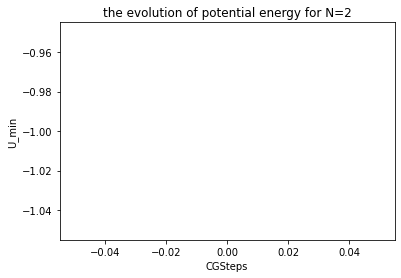

minimum potential energy for nanoparticle with 2 atoms is: -0.9999999999999999


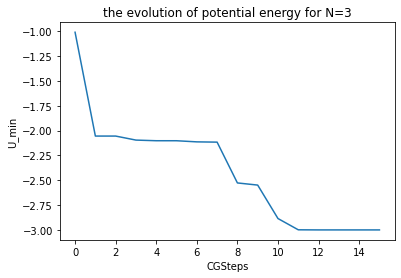

minimum potential energy for nanoparticle with 3 atoms is: -2.9999999999618416


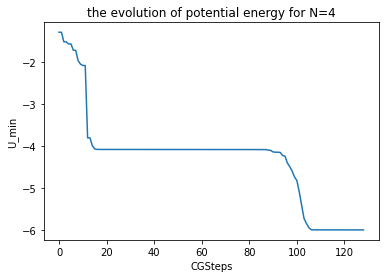

minimum potential energy for nanoparticle with 4 atoms is: -5.99999998704893


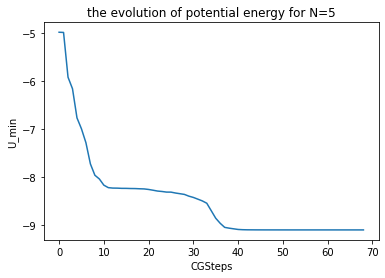

minimum potential energy for nanoparticle with 5 atoms is: -9.103852186050789


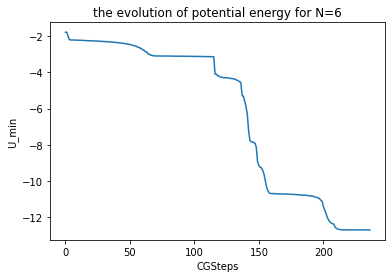

minimum potential energy for nanoparticle with 6 atoms is: -12.71205774666954


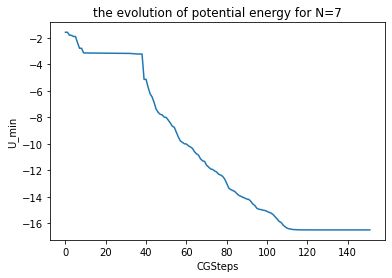

minimum potential energy for nanoparticle with 7 atoms is: -16.505382358017684


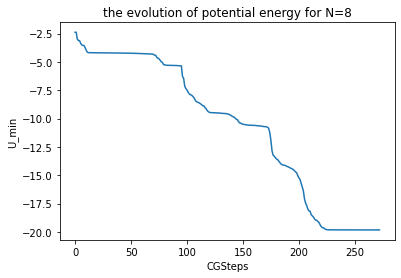

minimum potential energy for nanoparticle with 8 atoms is: -19.82148542965041


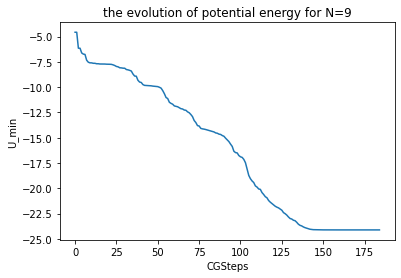

minimum potential energy for nanoparticle with 9 atoms is: -24.11335307672955


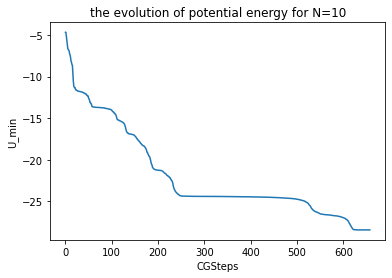

minimum potential energy for nanoparticle with 10 atoms is: -28.42251676092096


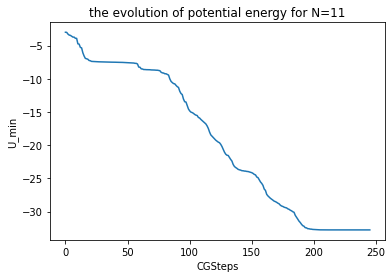

minimum potential energy for nanoparticle with 11 atoms is: -32.765954504387324


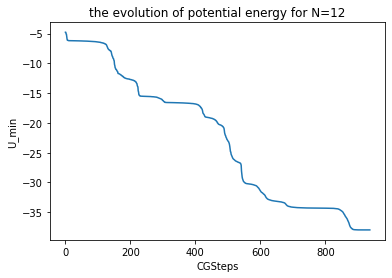

minimum potential energy for nanoparticle with 12 atoms is: -37.96758798517453


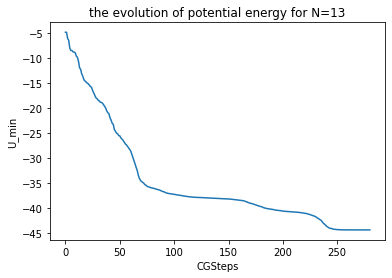

minimum potential energy for nanoparticle with 13 atoms is: -44.3267709920183


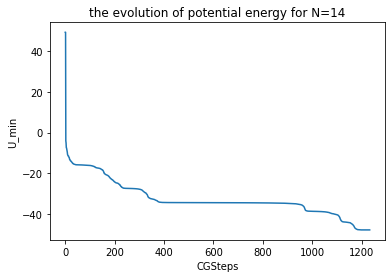

minimum potential energy for nanoparticle with 14 atoms is: -47.84514307149025


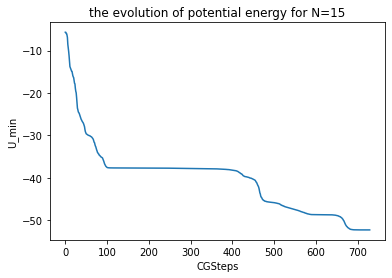

minimum potential energy for nanoparticle with 15 atoms is: -52.32259356366226


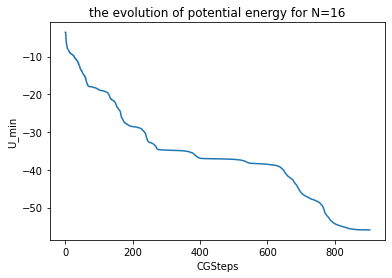

minimum potential energy for nanoparticle with 16 atoms is: -55.90516024714548


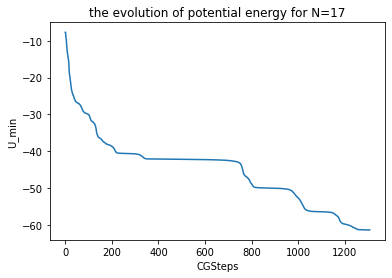

minimum potential energy for nanoparticle with 17 atoms is: -61.30696437836243


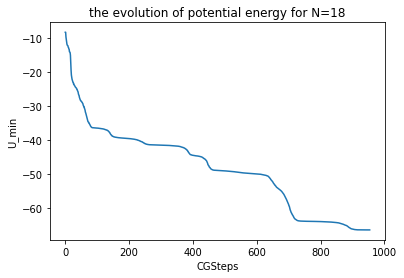

minimum potential energy for nanoparticle with 18 atoms is: -66.28444575770907


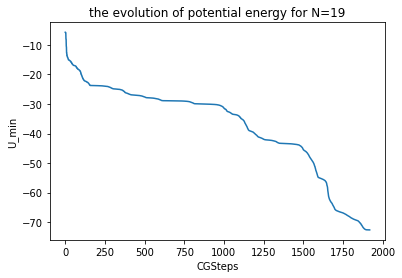

minimum potential energy for nanoparticle with 19 atoms is: -72.65821835383004


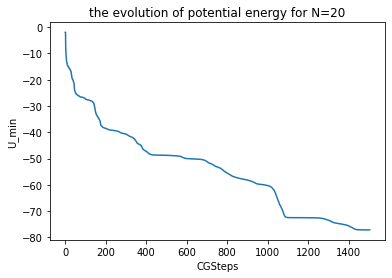

minimum potential energy for nanoparticle with 20 atoms is: -77.17699958630169


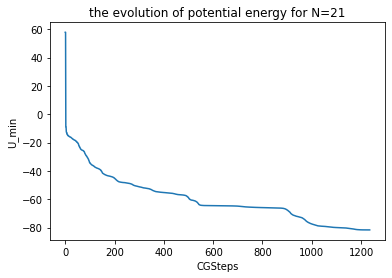

minimum potential energy for nanoparticle with 21 atoms is: -81.65073370139493


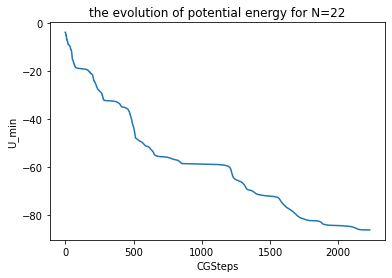

minimum potential energy for nanoparticle with 22 atoms is: -86.17976445113396


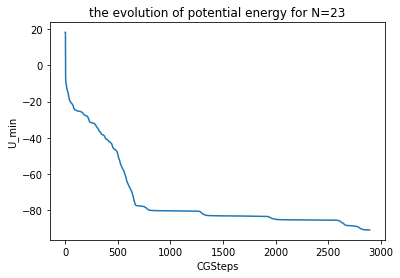

minimum potential energy for nanoparticle with 23 atoms is: -90.73283210034006


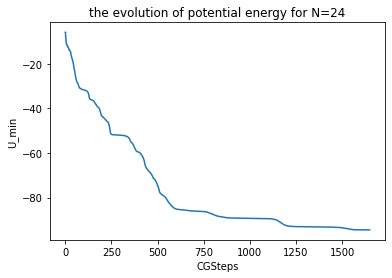

minimum potential energy for nanoparticle with 24 atoms is: -94.50055361971212


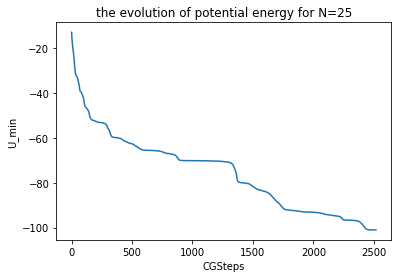

minimum potential energy for nanoparticle with 25 atoms is: -101.02665195775057


In [18]:
# Task 3

from ase import Atoms
from ase.visualize import view
from ase.io.trajectory import Trajectory

M = 1000
U_CSSteps_array = np.empty((24, 2))
    
ratio_N_V = 0.05 
factor = 1.0

for N in range(2, 26): 
    
    alpha = 0.0001*(N**(-2/3))    
    L = (N/ratio_N_V)**(1/3)
    U_min = math.inf   

    for i in range(M):
        
        r_i = r(N, L)
        U_cg, CGSteps, pos_U_df = conjugate_gradient(r_i, N) 
        
        if U_cg < U_min: 
            
            U_min = U_cg
            
            plot_steps = CGSteps
            plot_pos = pos_U_df.pos
            plot_U = pos_U_df.U
        
        #print(f'done with {i+1} simulations, U: {(U_cg)}')

    U_CSSteps_array[N-2] = U_min, plot_steps
    
    x = range(plot_steps)
    y = plot_U

    plt.plot(x, y)
    
    plt.title(f'the evolution of potential energy for N={N}')
    plt.xlabel('CGSteps')
    plt.ylabel('U_min')
    plt.show()
    
    print('minimum potential energy for nanoparticle with', N, 'atoms is:', U_min)
    
    pos_list = list(plot_pos)
    
    file_name = 'nano' + str(N) + '.traj'
    atom = 'C' + str(N)
    
    traj = Trajectory(file_name, 'w')
    for j in range(plot_steps): 
        nano = Atoms(atom, pos_list[j]*factor)
        traj.write(nano)

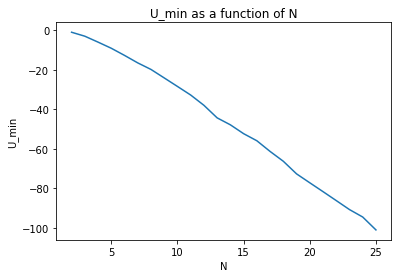

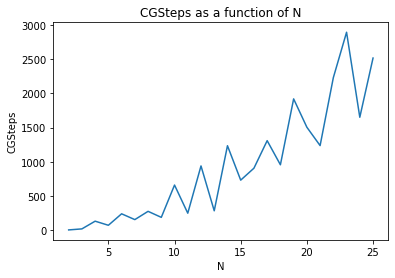

In [19]:
# Task 2

n = np.array(range(2, 26))

plt.plot(n, U_CSSteps_array[:, 0])

plt.title('U_min as a function of N')
plt.xlabel('N')
plt.ylabel('U_min')
plt.show()

plt.plot(n, U_CSSteps_array[:, 1])

plt.title('CGSteps as a function of N')
plt.xlabel('N')
plt.ylabel('CGSteps')
plt.show()

the macroscopic estimate for energy is given by the function [a + b*(N**(2/3) + c*N] with
a = -1.3406056986654087 
b = 9.960060771837936 
c = -7.406717212268829


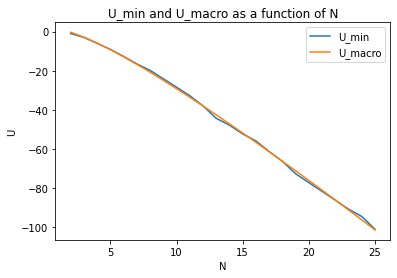

In [20]:
# Task 4
  
import scipy.optimize as optimization

def func(N, a, b, c):
    return a + b*(N**(2/3)) + c*N

a, b, c = optimization.curve_fit(func, n, U_CSSteps_array[:, 0])[0] 

print(f'the macroscopic estimate for energy is given by the function [a + b*(N**(2/3) + c*N] with\na = {a} \nb = {b} \nc = {c}')

U_macro = a + b*(n**(2/3)) + c*n

plt.plot(n, U_CSSteps_array[:, 0], label='U_min')
plt.plot(n, U_macro, label='U_macro')

plt.title('U_min and U_macro as a function of N')
plt.xlabel('N')
plt.ylabel('U')

plt.legend()
plt.show()